In [1]:
import numpy as np
from astropy.io import fits as fits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter as gf
from astropy.nddata import Cutout2D
import astropy.visualization as viz
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import astropy.coordinates as coords
from astropy.visualization.wcsaxes import WCSAxes
import astropy.visualization.wcsaxes.frame as frame
from astropy.table import Table
import pandas as pd
from scipy.stats import kde
import time
import pickle
import os
import reproject
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer
from IPython.display import Image
import seaborn as sns

%matplotlib notebook
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## cutout_func:
### 1. Takes the hscmap output fits file and produces a 3" x 3" cutout with the source at the center 
    
    This assures that all of the pre-stacked images will be the same size array-wise and the sources are in the center of each cutout
    
### 2. All of the images are then stacked, with the stacking being weighted by the inverse variance


In [2]:
# I start by importing my csv --> it contains all of the info on the 84 sources
result = pd.read_csv("everything_you_need.csv")
print("Columns in csv:")
print(result.columns)
print("Iterating thru these columns:\n", result.gfits[0:2])

Columns in csv:
Index(['Unnamed: 0', 'id_x', 'pos_err', 'DET_ML_F', 'rate_F', 'rate_F_err',
       'flux_F', 'flux_F_err', 'snr_F', 'exptime_F', 'cts_ap_F',
       'cts_ap_F_err', 'DET_ML_S', 'rate_S', 'rate_S_err', 'flux_S',
       'flux_S_err', 'snr_S', 'exptime_S', 'cts_ap_S', 'cts_ap_S_err',
       'DET_ML_H', 'rate_H', 'rate_H_err', 'flux_H', 'flux_H_err', 'snr_H',
       'exptime_H', 'cts_ap_H', 'cts_ap_H_err', 'HR', 'HR_lo_lim', 'HR_up_lim',
       'ra', 'dec', 'gfits', 'rfits', 'ifits', 'zfits', 'yfits'],
      dtype='object')
Iterating thru these columns:
 0    /Users/linaflorez/Desktop/ObsCos/COSMOS_resear...
1    /Users/linaflorez/Desktop/ObsCos/COSMOS_resear...
Name: gfits, dtype: object


In [5]:
"""
After playing with cutouts, I knew that in this case, the outputted 
cutouts would be 2D 18x18 arrays, so I initialized those arrays to 
fill as we iterated through the fits files

"""
num = np.zeros((18,18))
denom = np.zeros((18,18))

In [36]:
for i in range(len(result)):
    #Getting RA and Dec of source for cutout
    band = "gfits" #in this case
    respective_band = result[band].iloc[i]
    RA = result["ra"].iloc[i]
    DEC = result["dec"].iloc[i]
    hdulist = fits.open(respective_band)

    # Courtesy of hscMap 
    image = hdulist[1].data
    mask = hdulist[2].data
    variance = hdulist[3].data #for inverse variance

    # Prepping for cutout
    wcs = WCS(hdulist[1].header)
    coords = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)
    cut_center = SkyCoord(coords)
    size = 3 #arcsecs
    cutout_size = np.array([size, size]) * u.arcsec

    # Doing a cutout on the image array
    cutout = Cutout2D(image, cut_center, cutout_size, wcs=wcs)

    # Doing a cutout on the variance array
    adjusted_var = Cutout2D(variance, cut_center, cutout_size, wcs=wcs).data
    
    #added on/stacked to initialized num/denom arrays
    num += cutout.data/adjusted_var 
    denom += 1/adjusted_var

### Weighted Inverse Variance Formula: $\frac{\sum \frac{x_i}{\sigma_i^{2}}}{\sum \frac{1}{\sigma_i^{2}}}$

In [ ]:
#within the for loop
#this is the summation that takes place in the formula
num += cutout.data/adjusted_var 
denom += 1/adjusted_var
    
cutouts = num/denom 
print("Final cutout array shape:", np.shape(cutouts))

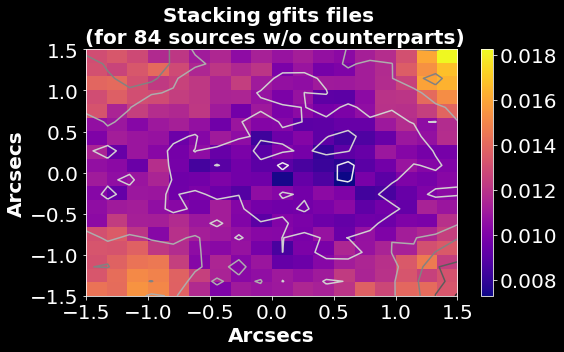

In [41]:
plt.style.use("dark_background")
fig,(ax1) = plt.subplots(1,1, figsize = (8,5))
title = "Stacking" + " " + band + " " + "files \n (for" + " " + str(result.shape[0]) + " " + "sources w/o counterparts)" 
plt.title(title, weight = "bold", size = 20)
plot = plt.imshow(cutouts, cmap = "plasma", extent=[-size/2 ,size/2,-size/2 ,size/2], aspect='auto')
plt.contour(cutouts, 5, extent=[-size/2 ,size/2,-size/2 ,size/2],cmap='Greys')
plt.xlabel("Arcsecs", weight = "bold", size = 20)
plt.ylabel("Arcsecs", weight = "bold", size = 20)
plt.tick_params("both", labelsize = 20)
cbar = fig.colorbar(plot)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("gfits_stacked.png")

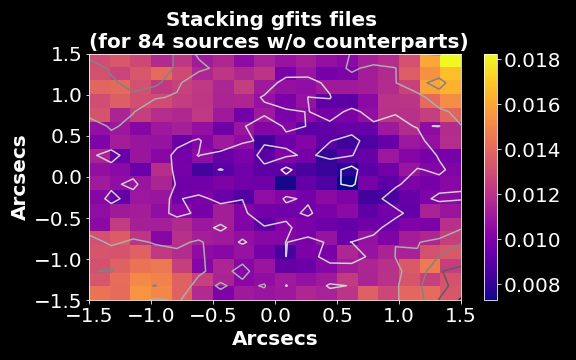

In [42]:
Image(filename="gfits_stacked.png")